In [77]:
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import io

from vis import *

254.97 325.05


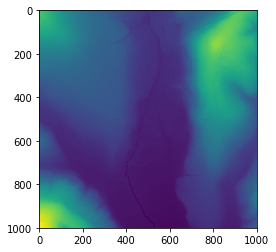

In [80]:
#nlin = 2000
#ncol = 3000
#dem = np.arange(nlin*ncol).reshape(nlin,ncol)
#dem = (np.sin(dem * 0.01) + np.random.rand(nlin,ncol))
#dem = np.minimum(dem, 50)
#print(dem.min(), dem.max(), dem.mean())
#plt.imshow(dem)
#print(np.histogram(dem))

dem = io.imread("/home/klemen/_repo_RVT/RVT_py/test_data/TM1_564_146.tif")

print(dem.min(),dem.max())
plt.imshow(dem)
plt.show()

In [97]:
tic = time.time()
_ = sky_view_factor(dem, 2, compute_svf=True, compute_opns=False, compute_asvf=False,
                    svf_n_dir=32, svf_r_max=10, svf_noise=0, asvf_dir=315, asvf_level=1)
toc = time.time()
print(toc-tic)

4.484355688095093


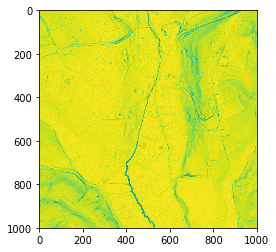

In [82]:
plt.imshow(_["svf"])
#_["svf"].shape

In [84]:
def horizon_shift_vector(num_directions=16, 
                         radius_pixels=10, 
                         min_radius=1,
                         ):
    
    # Initialize the output dict
    shift = {}

    # Generate angles and corresponding normal shifts in X (columns)
    # and Y (lines) direction
    angles = (2 * np.pi / num_directions) * np.arange(num_directions) 
    x = np.cos(angles)
    y = np.sin(angles)
    angles = np.round(np.degrees(angles), decimals=1)
    
    # Generate a range of radius values in pixels.
    # Make it finer for the selcted scaling.
    # By adding the last constant we make sure that we do not start with
    # point (0,0).
    scale = 3.
    radii = np.arange(radius_pixels*scale-scale+1) / scale + min_radius

    # For each direction compute all possible horizont point position
    # and round them to integers
    for i in range(num_directions):
        x_int = np.round(x[i] * radii, decimals=0)
        y_int = np.round(y[i] * radii, decimals=0)
        # consider only the minimal number of points
        # use the trick with set and complex nuber as the input
        coord_complex = set(x_int + 1j * y_int)
        # to sort proportional with increasing radius, 
        # set has to be converted to numpy array
        shift_pairs = np.array([(k.real, k.imag) for k in coord_complex]).astype(int)
        distance = np.sqrt(np.sum(shift_pairs**2, axis=1))
        sort_index = np.argsort(distance)
        # write for each direction shifts and corresponding distances
        shift[angles[i]] = {
            "shift": [(k[0],k[1]) for k in shift_pairs[sort_index]],
            "distance": distance[sort_index],
            }

    return shift

In [85]:
a=horizon_shift_vector(8, 10, 3)
for i in a.keys():
    print(f"angle {i}")
    for j in a[i]:
        print(f"{j}: {a[i][j]}")

angle 0.0
shift: [(3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0)]
distance: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
angle 45.0
shift: [(2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8)]
distance: [ 2.82842712  4.24264069  5.65685425  7.07106781  8.48528137  9.89949494
 11.3137085 ]
angle 90.0
shift: [(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12)]
distance: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
angle 135.0
shift: [(-2, 2), (-3, 3), (-4, 4), (-5, 5), (-6, 6), (-7, 7), (-8, 8)]
distance: [ 2.82842712  4.24264069  5.65685425  7.07106781  8.48528137  9.89949494
 11.3137085 ]
angle 180.0
shift: [(-3, 0), (-4, 0), (-5, 0), (-6, 0), (-7, 0), (-8, 0), (-9, 0), (-10, 0), (-11, 0), (-12, 0)]
distance: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
angle 225.0
shift: [(-2, -2), (-3, -3), (-4, -4), (-5, -5), (-6, -6), (-7, -7), (-8, -8)]
distance: [ 2.82842712  4.24264069  5.65685425  7.07106781  8.48528137  9.89949494
 11

In [91]:
def sky_view_factor_com_new(height_arr, 
                            radius_max=10, 
                            radius_min=1, 
                            num_directions=16,
                            compute_svf=True, 
                            #a_main_direction, a_poly_level, a_min_weight, compute_asvf=False, compute_opns=False
                            ):

    # increase the array shape for the radius_max on all 4 sides
    height = np.pad(height_arr, radius_max, mode='symmetric')

    #svf_out = None  # if compute_svf is False then function doesn't compute svf and returns False
    #asvf_out = None  # if compute_asvf is False then function doesn't compute asvf and returns False
    #opns_out = None  # if compute_opns is False then function doesn't compute opns and returns False

    # vector of movement
    move = horizon_shift_vector(num_directions=num_directions, radius_pixels=radius_max, min_radius=radius_min)

    # init the outputs
    if compute_svf:
        svf_out = np.zeros(height.shape, dtype=np.float32)
    #if compute_opns:
    #    opns_out = np.zeros(count_height, dtype=np.float32)
    #if compute_asvf:
    #    asvf_out = np.zeros(count_height, dtype=np.float32)
    #    w_m = a_min_weight  # compute weights
    #    w_a = np.deg2rad(a_main_direction)
    #    weight = np.arange(num_directions) * dir_step
    #    weight = (1 - w_m) * (np.cos((weight - w_a) / 2)) ** a_poly_level + w_m

    # look into each direction...
    for direction in move:
        # reset maximum at each iteration - at each new direction
        max_slope = np.zeros(height.shape, dtype=np.float32) - 1000

        # ... and to the search radius
        for i, radius in enumerate(move[direction]["distance"]):
            # get shift index from move dictionary
            shift_indx = move[direction]["shift"][i]
            # estimate the slope
            _ = (np.roll(height, shift_indx, axis=(0,1)) - height) / radius
            # compare to the previus max slope and keep the larges
            max_slope = np.maximum(max_slope, _)
        
        # convert to angle and compute directional SVF
        svf_out = svf_out + (1 - np.sin(np.arctan(max_slope)))

    return svf_out

In [103]:
tic = time.time()
a = sky_view_factor_com_new(dem/20., 
                            radius_max=10, 
                            radius_min=1, 
                            num_directions=32,
                            compute_svf=True)

toc = time.time()
print(toc-tic)

2.758284568786621


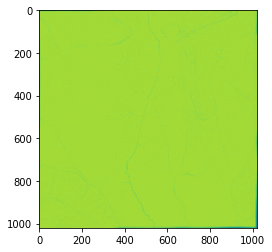

In [104]:
plt.imshow(a)